<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/mask_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model evaluation (inference) on COCO 2017 dataset

The following models will be evaluated:

| Model | Backbone | Model Image Size | Parameters | GFLOPs
| --- | --- | --- | --- | --- |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5s |  Custom | 320x320 | 7.3M |  |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |

<br>

**Note: GPU Runtime needed (hosted or local)**

*Example experiment: Tesla K80, 460.32.03, 11441 MiB, batch_size=8, workers=2*

In [ ]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
NVIDIA GeForce GTX 960, 465.19.01, 4036 MiB


### Initialization

In [ ]:
# Parameters

dataset_name = 'PWMFD'  # Dataset to evaluate: 'MASKD' or 'PWMFD'

custom_results_file = None # Select None to generate results file name automatically from model info  

img_res = 640  # Image resolution (for YOLO models), try 640, 320 or 160
num_workers = 2  #  Data loader workers
batch_size = 1  # Data loader batch size

th = 0.7  # Threshold for confidence score of predicted bboxes to show

# Directories

load_ckpt_path = f'/home/ioanna/object-detection-checkpoints/pretrained/PWMFD_yolov5s_sgd_ep50_lr01_trainres640_run/weights/last.pt'  # Model checkpoint to load
model_info = load_ckpt_path.split('/')[-3].replace(dataset_name + '_', '').replace('run',f'infres{img_res}') + '_' +  load_ckpt_path.split('/')[-4]  # Get full model parameter info from weight folder name

import os
root_dir = os.getcwd()  # Root dir of project
dataset_dir = os.path.join(root_dir,f'dataset_{dataset_name}')

img_dir = os.path.join(dataset_dir,'images')
val_img_dir = os.path.join(img_dir,'val_images')

label_dir = os.path.join(dataset_dir,'labels')
val_label_dir = os.path.join(label_dir,'val_images')

ann_dir = os.path.join(dataset_dir,'annotations')

### Get requirements
*Note: Restart runtime after installation*

In [ ]:
# Clone asset files
!cd {root_dir}
!git clone https://github.com/joangog/object-detection-assets
!mv -n {os.path.join(root_dir,'object-detection-assets','scripts')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','config')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','requirements.txt')} ./
!rm -rf {os.path.join(root_dir,'object-detection-assets')}


Cloning into 'object-detection-assets'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 155 (delta 54), reused 126 (delta 28), pack-reused 0
Receiving objects: 100% (155/155), 33.56 KiB | 545.00 KiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
# Install packages
!cd {root_dir}
!pip install -r requirements.txt

  Cloning https://github.com/googlecolab/colabtools.git to /tmp/pip-req-build-v6arca50
  Running command git clone --filter=blob:none -q https://github.com/googlecolab/colabtools.git /tmp/pip-req-build-v6arca50
  Resolved https://github.com/googlecolab/colabtools.git to commit b1fcde879ef0cd2fbfe66034676127873e1f9c0f
  Preparing metadata (setup.py) ... - done


In [ ]:
# Install Yolov5
!cd {root_dir}
!git clone https://github.com/joangog/yolov5
!pip install -r {os.path.join(root_dir,'yolov5','requirements.txt')}

Cloning into 'yolov5'...
remote: Enumerating objects: 9885, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 9885 (delta 45), reused 33 (delta 14), pack-reused 9801
Receiving objects: 100% (9885/9885), 10.31 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (6837/6837), done.


In [ ]:
# Install Yolov3
!cd {root_dir}
!git clone https://github.com/ultralytics/yolov3
!pip install -r {os.path.join(root_dir,'yolov3','requirements.txt')}

Cloning into 'yolov3'...
remote: Enumerating objects: 9961, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 9961 (delta 18), reused 63 (delta 14), pack-reused 9858
Receiving objects: 100% (9961/9961), 9.37 MiB | 3.42 MiB/s, done.
Resolving deltas: 100% (6683/6683), done.


In [ ]:
# Install unrar command
if os.geteuid() != 0:  # If not root, ask for sudo priviledges
  from getpass import getpass
  password = getpass('Insert sudo password:')
  !echo {password} | sudo -S -k apt-get install unrar
else:
  !apt-get install unrar

Insert sudo password:··········
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
The following packages were automatically installed and are no longer required:
  linux-headers-5.4.0-87-generic linux-hwe-5.4-headers-5.4.0-87
  linux-image-5.4.0-87-generic linux-modules-5.4.0-87-generic
  linux-modules-extra-5.4.0-87-generic
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


### Import packages

In [ ]:
from google.colab import files
from google.colab import drive
from google.colab.output import eval_js

import os, sys
import math
import time
import copy
import re
import io

import numpy as np
import pandas as pd
import json
import xml.etree.ElementTree as ET
import html

import PIL
import cv2
import IPython
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from pycocotools import coco
from pycocotools import mask as cocomask

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.engine as SE
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

### Define auxiliary functions

In [ ]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, M.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, M.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device, img_res=None):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = SU.MetricLogger(delimiter="  ")
    header = 'Test:'
    coco = SCU.get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    # Get label names
    label_ids = data_loader.dataset.coco.getCatIds()
    label_info = data_loader.dataset.coco.loadCats(label_ids)
    label_names = [label['name'] for label in label_info]
    labels = dict(zip(label_ids, label_names))  # Label dictionary with id-name as key-value
    labels_inv = dict(zip(label_names, label_ids))  # Inverse label dictionary with name-id as key-value

    for images, targets in metric_logger.log_every(data_loader, 100, header):

        # If the batch size is 1 and the sole image has no annotations then skip it:
        if len(targets) == 1:
            if len(targets[0]) == 0:
                continue

        images = list(img.to(device) for img in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
            images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Get model predictions
        model_time = time.time()
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
            model.inplace = True
            outputs = model(images, size=img_res)
        else:
            outputs = model(images)
        model_time = time.time() - model_time

        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
            # Format outputs to COCO format
            outputs_formatted = []
            for img_outputs in outputs.xyxy:
                output_bboxes = img_outputs[:, :4]
                output_scores = img_outputs[:, 4]
                output_labels = img_outputs[:, 5].to(cpu_device).apply_(
                    lambda x: labels_inv[label_names[int(x)]])  # Convert YOLO label ids to COCO label ids
                outputs_formatted.append({
                    'boxes': output_bboxes,
                    'scores': output_scores,
                    'labels': output_labels
                })
            outputs = outputs_formatted

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        res = {target[0]["image_id"]: output for target, output in zip(targets, outputs) if len(target) != 0}

        # Get prediction evaluation
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time

        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    # Model FPS
    batch_size = data_loader.batch_size
    fps = batch_size / metric_logger.meters['model_time'].global_avg

    # Model maximum memory usage
    MB = 1024.0 * 1024.0
    max_mem = torch.cuda.max_memory_allocated() / MB  # in MegaBytes

    return coco_evaluator, fps, max_mem, outputs

In [ ]:
def add_motion_blur(img, kernel_size, kernel_angle):
  kernel = np.zeros((kernel_size, kernel_size))
  if kernel_angle == 'v':  # Vertical Motion Blur
    kernel[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
  elif kernel_angle == 'h':  # Horizontal Motion Blur
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
  kernel /= kernel_size
  return cv2.filter2D(img, -1, kernel)

# Converts base64 image from JS reply to PIL image
def js_to_image(js_reply):  
  image_bytes = b64decode(js_reply.split(',')[1])
  img = PIL.Image.open(io.BytesIO(image_bytes))
  return img

# Convert OpenCV Rectangle bbox overlay image into base64 byte string
def bbox_to_bytes(bbox_array):
  # Convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # Format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # Format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

# JavaScript functions to print live video stream using webcam
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>FPS: </span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### (Optional) Connect to GDrive for storage access
*Note: Not possible with local runtime*

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Download Mask dataset

In [ ]:
!cd {root_dir}
!mkdir -p dataset_{dataset_name}
!cd {dataset_dir}
!mkdir -p {img_dir} {ann_dir} {label_dir}
!cd {img_dir}
!mkdir {val_img_dir}
!cd {label_dir}
!mkdir {val_label_dir}

In [ ]:
if dataset_name == 'MASKD':

  !cd {root_dir}

  # Download validation images
  if not os.path.exists('val_images.zip'):
    !gdown --id '101F2k6PJ-tD_uwlsCG7zzGF9ILJW01M1'
  !unzip -q -n 'val_images.zip' -d {img_dir}

  # Download validation annotations
  if not os.path.exists('val.json'):
    !gdown -O {os.path.join(ann_dir,'val.json')} --id '1YLV7-7vmiNdFI8Xpdx_jbhnxfgQRWrgF'

elif dataset_name == 'PWMFD':

  # Download validation images
  if not os.path.exists('val_images.rar'):
    !gdown -O 'val_images.rar' --id  1ZXuSwoRvTnnca81RUj3kMoLFZJ6auAwT
  !unrar e -idq -o- 'val_images.rar' -d {val_img_dir}

  # Convert annotation files from PASCAL VOC .xml to COCO .json (only for PWMFD dataset)
  
  label_ids = {'with_mask': 1, 'without_mask': 2, 'incorrect_mask': 3}  # BG class is 0

  ann_count = 0  # Annotation counter

  images = []
  categories = []
  annotations = []

  xml_files = os.listdir(val_img_dir)
  xml_files = [file for file in xml_files if '.xml' in file]

  # Categories
  for label in label_ids:
    categories.append(
        {
          'supercategory': 'none',
          'id': label_ids[label],
          'name': label
        }
    )

  for xml_file in xml_files:  # For each annotation file

    tree = ET.parse(os.path.join(val_img_dir,xml_file))
    root = tree.getroot()

    # Image
    file_name = root[0].text
    height = int(root[1][1].text)
    width = int(root[1][0].text)
    id = int(re.sub(r'^\D*0*', '', file_name).replace('.jpg',''))
    images.append(
        {
          'file_name': file_name,
          'height': height,
          'width': width,
          'id': id
        }
    )
    
    # Annotations
    if len(root) > 2:  # If annotations (object attribute) exist, they will be after the 1-index attribute in the XML
      for i in range(2,len(root)):
        category_id = label_ids[root[i][0].text]
        xmin = int(root[i][1][0].text)
        ymin = int(root[i][1][1].text)
        xmax = int(root[i][1][2].text)
        ymax = int(root[i][1][3].text)
        annotations.append(
            {
              'iscrowd': 0,
              'image_id': id,
              'bbox': [xmin, ymin, xmax-xmin, ymax-ymin],
              'area': (xmax-xmin) * (ymax-ymin),
              'category_id': category_id,
              'ignore': 0,
              'id': ann_count,
              'segmentation': []
            }
        )
        ann_count += 1

  coco_dict = {
  'info': {},
  'images': images,
  'categories': categories,
  'annotations': annotations,
  'licenses': []
  }

  with open(os.path.join(ann_dir,f'val.json'),'w') as outfile:
    json.dump(coco_dict, outfile, indent=3)


# Copy COCO annotations in images folder
!cp {os.path.join(ann_dir,'val.json')} {val_img_dir}

Downloading...
From: https://drive.google.com/uc?id=1ZXuSwoRvTnnca81RUj3kMoLFZJ6auAwT
To: /content/val_images.rar
100% 204M/204M [00:01<00:00, 138MB/s]


### Load Mask dataset

In [ ]:
val_ann_file = 'val.json'  # annotations
val_ann_path = os.path.join(val_img_dir,val_ann_file)  

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create dataset
val_dataset = CocoDetection(val_img_dir, val_ann_path, transforms = transforms)

# Create data loader
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

# Get label names
if dataset_name == 'MASKD':
  label_ids = [1,2]
  label_names = ['mask', 'no_mask']
elif dataset_name == 'PWMFD':
  label_ids = [1,2,3]
  label_names = ['with_mask', 'without_mask', 'incorrect_mask']
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value
label_colors = {1: (0,255,0), 2:(255,0,0), 3: (255,255,0)}

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Load model

YOLOv5 🚀 v6.0-83-g6903251 torch 1.9.0+cu102 CUDA:0 (NVIDIA GeForce GTX 960, 4036MiB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients
Adding AutoShape... 


-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv5s
	- Parameters: 7.1M
	- GFLOPs: 16.3


### (Optional) Test model with image sample
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*


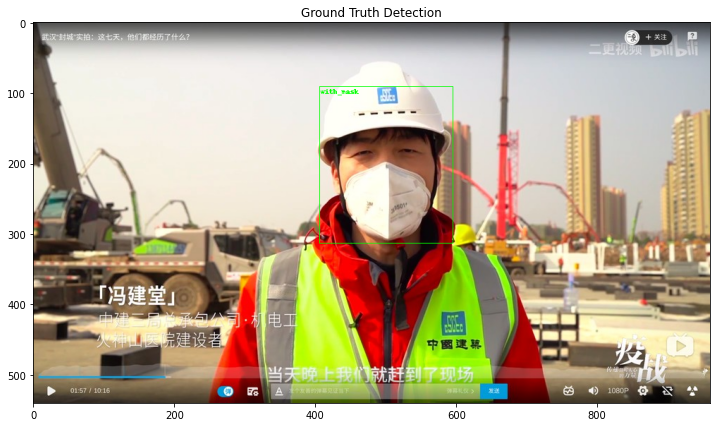

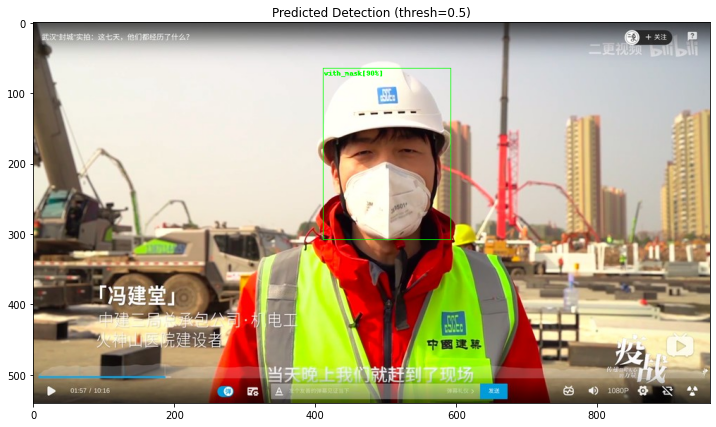

In [ ]:
%matplotlib inline

# Parameters
img_from_path = False
img_path = '/content/test.jpg'  # Only for image from path
img_id = 32  # Only for image not from path (image from val dataset)

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
if img_from_path:
  img = cv2.imread(img_path)
else:
  img = cv2.imread(os.path.join(val_img_dir,val_dataset.coco.loadImgs([img_id])[0]['file_name']))

img = PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Format image
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = val_dataset.coco.loadAnns(val_dataset.coco.getAnnIds([img_id]))

# Draw ground truth bboxes
if not img_from_path:  # If the image is not from path (if it is, ground truth doesn't exist)
  true_bboxes = SE.convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
  true_labels = [labels[obj['category_id']] for obj in img_anns]
  true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels, colors=[label_colors[obj['category_id']] for obj in img_anns])
  plt.figure(figsize = (25,7))
  plt.title('Ground Truth Detection')
  plot = plt.imshow(F.to_pil_image(true_img))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img], size=img_res)
  else:    
    pred = model([img_torchvision])

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_label_ids = []
  pred_labels = []
  for bbox in pred.xyxy[0]:  # For every bbox
    conf = bbox[4]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox[:4])
      label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
      pred_label_ids.append(label_id)  
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

# For torchvision models
else:
  for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
    conf = pred[0]['scores'][i]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox)
      label_id = pred[0]['labels'][i]
      pred_label_ids.append(label_id)
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

# Draw predicted bboxes
if len(pred_bboxes) != 0:
  pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels, colors=[label_colors[label_id] for label_id in pred_label_ids])
else:  # If no bboxes are found just return the image
  pred_img = img_tensor
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### (Optional) Test model on webcam video stream
*Note: FPS is largely affected by latency between webcam and colab. For accurate FPS run YOLOv5 locally using the detect.py script:*

*python detect.py --weights /path/ --source 0 --imgsz 320 --view-img --conf-thres 0.5*

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Start streaming video from webcam
video_stream()

# FPS monitor
fps = 0

# Initialze bounding box to empty
bbox = ''
count = 0 

while True:
    
    js_reply = video_frame(fps, bbox)
    if not js_reply:
        break

    # Convert JS response to PIL Image
    frame = js_to_image(js_reply["img"])
    plt.imshow(frame)

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Format frame (for torchvision models)
    frame_tensor = F.convert_image_dtype(F.to_tensor(frame),torch.uint8)
    frame_torchvision = torch.div(frame_tensor,255).float().to(device)

    # Generate model predictions
    model.eval()
    model_time = time.time()
    with torch.no_grad():
      if 'YOLO' in model_name:
        pred = model(frame, size=img_res)
      else:    
        pred = model([frame_torchvision])
    model_time = time.time() - model_time
    fps = int(1/model_time)

    # Get predicted bboxes
    # For YOLO models
    if 'YOLO' in model_name:  
      pred_bboxes = []
      pred_label_ids = []
      pred_labels = []
      for img in pred.xyxy: # For every image
        for bbox in img:  # For every bbox of that image
          conf = bbox[4]
          if conf > th:  # Show only bboxes with high confidence score
            pred_bboxes.append(bbox[:4])
            label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
            pred_label_ids.append(label_id)  
            pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)
    # For torchvision models
    else:
      for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
        conf = pred[0]['scores'][i]
        if conf > th:  # Show only bboxes with high confidence score
          pred_bboxes.append(bbox)
          label_id = pred[0]['labels'][i]
          pred_label_ids.append(label_id)
          pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)  

    predictions = zip(pred_label_ids, pred_labels, pred_bboxes)

    # Loop through detections and draw them on transparent overlay image
    for label_id, label, bbox in predictions:
      left, top, right, bottom = bbox
      left = int(left); top = int(top); right = int(right); bottom = int(bottom)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), label_colors[label_id], 2)
      bbox_array = cv2.putText(bbox_array, "{}".format(label),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        label_colors[label_id], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

### Evaluate model
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*

*Note 2: To get accurate maximum GPU memory usage logging, restart runtime when choosing a different model.*

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f'Model: {model_name} ({model_info})')

# Evaluate model
evaluator, fps, max_mem, outputs = evaluate(model, val_data_loader, device, img_res=img_res)

print(f'\nFPS: {fps}\n')

Model: YOLOv5s (yolov5s_sgd_ep50_lr01_trainres640_infres640_pretrained)
Test:  [   0/1820]  eta: 0:05:57  model_time: 0.0225 (0.0225)  evaluator_time: 0.0924 (0.0924)  time: 0.1967  data: 0.0708  max mem: 72
Test:  [ 100/1820]  eta: 0:01:28  model_time: 0.0189 (0.0207)  evaluator_time: 0.0216 (0.0218)  time: 0.0446  data: 0.0010  max mem: 93
Test:  [ 200/1820]  eta: 0:01:18  model_time: 0.0217 (0.0202)  evaluator_time: 0.0215 (0.0210)  time: 0.0496  data: 0.0011  max mem: 145
Test:  [ 300/1820]  eta: 0:01:14  model_time: 0.0220 (0.0205)  evaluator_time: 0.0214 (0.0211)  time: 0.0484  data: 0.0011  max mem: 145
Test:  [ 400/1820]  eta: 0:01:09  model_time: 0.0204 (0.0208)  evaluator_time: 0.0213 (0.0212)  time: 0.0473  data: 0.0010  max mem: 145
Test:  [ 500/1820]  eta: 0:01:05  model_time: 0.0220 (0.0210)  evaluator_time: 0.0216 (0.0213)  time: 0.0489  data: 0.0011  max mem: 163
Test:  [ 600/1820]  eta: 0:01:00  model_time: 0.0222 (0.0211)  evaluator_time: 0.0216 (0.0213)  time: 0.0531

### Save metric results

In [ ]:
cols = ['model', 'model_img_size', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score']
model = []
model_img_size_arr = []
model_params_arr = []
model_gflops_arr = []
fps_arr = []
max_mem_arr = []
iou_type = []
metric = []
iou = []
area = []
max_dets = []
score = []

# Set column values
for curr_iou_type, coco_eval in evaluator.coco_eval.items():
  model += [model_info for i in range(0,12)]
  model_img_size_arr += [model_img_size[1] for i in range(0,12)]
  model_params_arr += [model_params for i in range(0,12)]
  model_gflops_arr += [model_gflops for i in range(0,12)]
  fps_arr += [fps for i in range(0,12)]
  max_mem_arr += [max_mem for i in range(0,12)]
  iou_type += [curr_iou_type for i in range(0,12)]
  metric += ['avg_precision' for i in range(0,6)] + ['avg_recall' for i in range(0,6)]
  iou += ['0.50:0.95', '0.50', '0.75'] + ['0.50:0.95' for i in range(0,9)]
  area += ['all' for i in range(0,3)] + ['small', 'medium', 'large'] + ['all' for i in range(0,3)] + ['small', 'medium', 'large'] 
  max_dets += [100 for i in range(0,6)] + [1, 10] + [100 for i in range(0,4)]
  score += list(coco_eval.stats)

results = pd.DataFrame(np.column_stack([model, model_img_size_arr, model_params_arr, model_gflops_arr, fps_arr, max_mem_arr, iou_type, metric, iou, area, max_dets, score]))
results.columns = cols

In [ ]:
# Save to file

results_dir = root_dir

gpu = torch.cuda.get_device_name(0).lower()  # Keep only short gpu name
for pattern in [' ', 'tesla', 'geforce', 'nvidia']:  
  gpu = gpu.replace(pattern,'')

if custom_results_file:
  results_file = custom_results_file
else:
  results_file = f'{dataset_name}_{gpu}_{model_info}_metrics.csv'
results_path = os.path.join(results_dir, results_file)

if os.path.exists(results_path):
      os.remove(results_path)
with open(results_path, 'w') as outfile: 
    results.to_csv(outfile)

### (Optional) Save results to GDrive

In [ ]:
# Save to GDrive
gdrive_results_dir = f'/content/drive/MyDrive/object-detection-results/{dataset_name}'
!mkdir gdrive_results_dir
gdrive_metric_results_path = os.path.join(gdrive_results_dir, metric_results_file)
if os.path.exists(gdrive_metric_results_path):
      os.remove(gdrive_metric_results_path)
with open(gdrive_metric_results_path, 'w') as outfile: 
    metric_results.to_csv(outfile)

NameError: ignored